In [ ]:
__author__ = "Matteo Pariset"

# Prepare Cell evolution dataset
v2

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import Pipeline
from umap import UMAP
import joblib
import matplotlib.pyplot as plt
import seaborn as sbn

import ipywidgets

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rcParams["figure.figsize"] = (6.4, 4.8)

plt.rcParams['font.family'] = 'serif'
sns.set_context(context='talk', font_scale=.9)
palette = ['#1A254B', '#114083', '#A7BED3', '#F2545B', '#A4243B']

cmap = LinearSegmentedColormap.from_list('cmap', palette, N=18)

colors = ['#1A254B', '#114083', '#A7BED3', '#FFFFFF', '#F2545B', '#A4243B']
from matplotlib.colors import LinearSegmentedColormap
bcmap = LinearSegmentedColormap.from_list('bcmap', colors, N=100)

In [3]:
def process_dataset(dataset):
    dataset["Condition"] = dataset["Condition"].str.lower().str.strip().str.replace(" + ", "_", regex=False).str.replace(" ", "_")
    return dataset

In [4]:
def broadcast(func, tree):
    return {k: func(k, v) for k, v in tree.items()}

In [5]:
raw_data_dict = {
    8: process_dataset(pd.read_csv("./temporal_4i/scdata_and_conditions_MelTimecourse2_8h_norm.csv")).dropna(),
    24: process_dataset(pd.read_csv("./temporal_4i/scdata_and_conditions_MelTimecourse2_24h_norm.csv")).dropna(),
    48: process_dataset(pd.read_csv("./temporal_4i/scdata_and_conditions_MelTimecourse2_48h_norm.csv")).dropna(),
}

broadcast(lambda time, df: df.insert(0, "time", time), raw_data_dict);

In [6]:
raw_data = pd.concat(raw_data_dict.values()).set_index("time")
# Do not use measurements without secondary Abs (sec.abcl) nor cell lines (cl)
raw_data = raw_data.query(f"Condition not in ['cl', 'sec.abcl']")
raw_data.shape

(317685, 79)

In [7]:
selected_columns_mask = np.logical_not(raw_data.columns.str.contains(r"(Condition|Intensity_sum)"))
selected_columns = raw_data.columns[selected_columns_mask].to_numpy()
selected_columns

/tmp/ipykernel_27056/974992371.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  selected_columns_mask = np.logical_not(raw_data.columns.str.contains(r"(Condition|Intensity_sum)"))


array(['Nuclei_Morphology_Area', 'Nuclei_Morphology_Circularity',
       'Nuclei_Morphology_Convexity', 'Nuclei_Morphology_Eccentricity',
       'Nuclei_Morphology_Elongation',
       'Nuclei_Morphology_Equivalent_Diameter',
       'Nuclei_Morphology_Extent', 'Nuclei_Morphology_Major_Axis_Length',
       'Nuclei_Morphology_Mean_Radius', 'Nuclei_Morphology_Perimeter',
       'Nuclei_Morphology_Roundness', 'Morphology_Area',
       'Morphology_Perimeter', 'Morphology_Eccentricity',
       'Morphology_Extent', 'Morphology_Convexity',
       'Morphology_Circularity', 'Morphology_Roundness',
       'Morphology_Elongation', 'Morphology_Equivalent_Diameter',
       'Morphology_Major_Axis_Length', 'Morphology_Mean_Radius',
       'Nuclei_Intensity_mean_DAPI', 'Nuclei_Intensity_mean_MelA',
       'Nuclei_Intensity_mean_Sox9', 'Nuclei_Intensity_mean_pS6k1',
       'Nuclei_Intensity_mean_PCNA', 'Nuclei_Intensity_mean_pAKT',
       'Nuclei_Intensity_mean_pEGFR', 'Nuclei_Intensity_mean_aTUB',
     

In [8]:
timesteps = dict(zip([8, 24, 48], [None, None, None]))

### Normalize measurements

In [9]:
scaler = RobustScaler()

In [10]:
scaler.fit(raw_data.loc[:, selected_columns].to_numpy())

RobustScaler()

In [11]:
data = pd.DataFrame(scaler.transform(raw_data.loc[:, selected_columns].to_numpy()), index=raw_data.index, columns=selected_columns)

In [12]:
data

,Nuclei_Morphology_Area,Nuclei_Morphology_Circularity,Nuclei_Morphology_Convexity,Nuclei_Morphology_Eccentricity,Nuclei_Morphology_Elongation,Nuclei_Morphology_Equivalent_Diameter,Nuclei_Morphology_Extent,Nuclei_Morphology_Major_Axis_Length,Nuclei_Morphology_Mean_Radius,Nuclei_Morphology_Perimeter,...,Intensity_mean_PCNA,Intensity_mean_pAKT,Intensity_mean_pEGFR,Intensity_mean_aTUB,Intensity_mean_pERK,Intensity_mean_Ki67,Intensity_mean_pMET,Intensity_mean_CD45,Intensity_mean_ClCasp3,Intensity_mean_TotProtein
time,,,,,,,,,,,,,,,,,,,,,
8,-0.274112,-1.161924,-1.024294,-2.117290,-1.385679,-0.282769,-0.084229,-0.867892,-0.119449,0.369746,...,1.174501,2.740725,2.050947,1.256621,1.159009,1.124681,3.885301,1.724430,4.769124,0.986931
8,-1.140102,-0.974085,-2.296770,-1.142132,-0.906933,-1.328908,-1.082079,-1.446597,-1.284489,-0.749805,...,1.947383,0.591499,-0.120799,-0.599442,0.443334,-0.119510,1.289209,0.819025,2.304385,0.167991
8,0.232487,-2.525538,-3.063312,-2.752453,-1.588989,0.227103,-0.612237,-0.467192,-0.390752,2.513139,...,0.731087,1.763594,2.121434,0.368434,0.297882,1.091764,3.158411,3.025618,4.459429,1.128970
8,1.428426,-2.658096,-2.244442,-0.976498,-0.802136,1.259917,-1.410106,0.608182,0.698723,4.191742,...,-0.298335,0.704826,1.046160,-0.100396,0.284098,0.472126,1.877242,1.778915,2.808882,0.744667
8,2.323858,-2.901381,-3.469861,-1.247588,-0.969757,1.928539,-1.712069,1.127107,1.269271,5.900066,...,0.724930,0.843195,0.548065,-0.587789,0.705410,0.499171,2.220354,2.300006,3.848469,0.693036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,0.387817,0.070057,0.248918,0.217052,0.233703,0.373164,-0.586462,0.387225,0.354827,0.241766,...,1.390305,-0.267020,-0.129130,-0.933744,-0.056844,-0.075425,0.585093,0.087433,0.720039,-0.116135
48,0.234518,-0.719242,-1.102182,0.751547,0.944274,0.229041,-1.090583,0.807440,-0.391457,0.556617,...,-0.478012,-0.468090,-0.480493,-1.000736,-0.167395,-0.468474,-0.221170,-0.223243,-0.112052,-0.643655
48,-0.813198,-0.104008,-0.506699,0.295291,0.324560,-0.899925,-0.099363,-0.708792,-0.843792,-0.744591,...,-0.415651,0.115202,-0.385142,-0.810979,-0.117076,-0.085124,0.239919,-0.163458,0.082211,-0.308923


In [13]:
# conditions = raw_data['Condition']
conditions = raw_data['Condition']
conditions.shape

(317685,)

### Visualize dataset

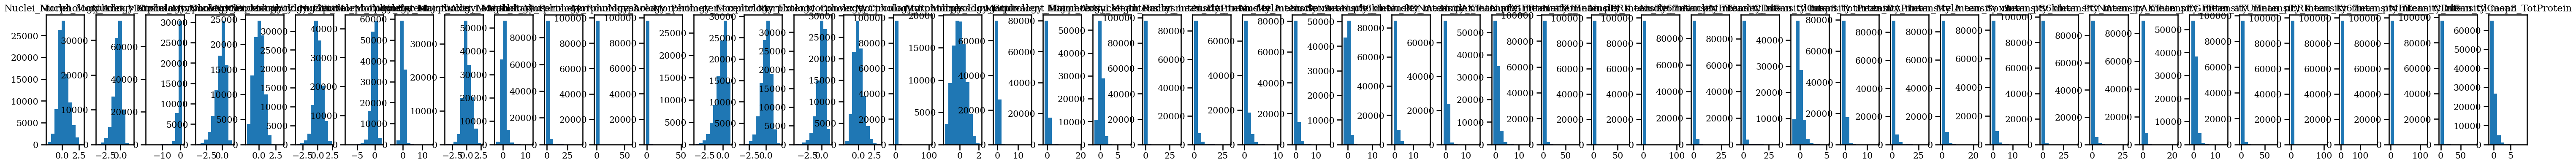

In [14]:
data.loc[8].hist(data.columns, grid=False, layout=(1, 79), figsize=(120, 4));

In [15]:
drugs = conditions.unique()
drugs

array(['ixazomib', 'everolimus', 'olaparib', 'paclitaxel',
       'vemurafenib_cobimetinib', 'decitabine', 'control', 'palbociclib',
       'trametinib_panobinostat', 'dacarbazine', 'panobinostat',
       'sorafenib', 'trametinib_dabrafenib', 'erlotinib', 'crizotinib',
       'cisplatin_olaparib', 'trametinib_erlotinib', 'imatinib',
       'regorafenib', 'pomalidomide_carfilzomib_dexamethasone',
       'trametinib_midostaurin', 'mln2480', 'vindesine', 'midostaurin',
       'cisplatin', 'staurosporine', 'temozolomide', 'dabrafenib',
       'lenalidomide', 'trametinib', 'dexamethasone', 'hydroxyurea',
       'ixazomib_lenalidomide_dexamethasone', 'melphalan', 'ulixertinib',
       'dasatinib'], dtype=object)

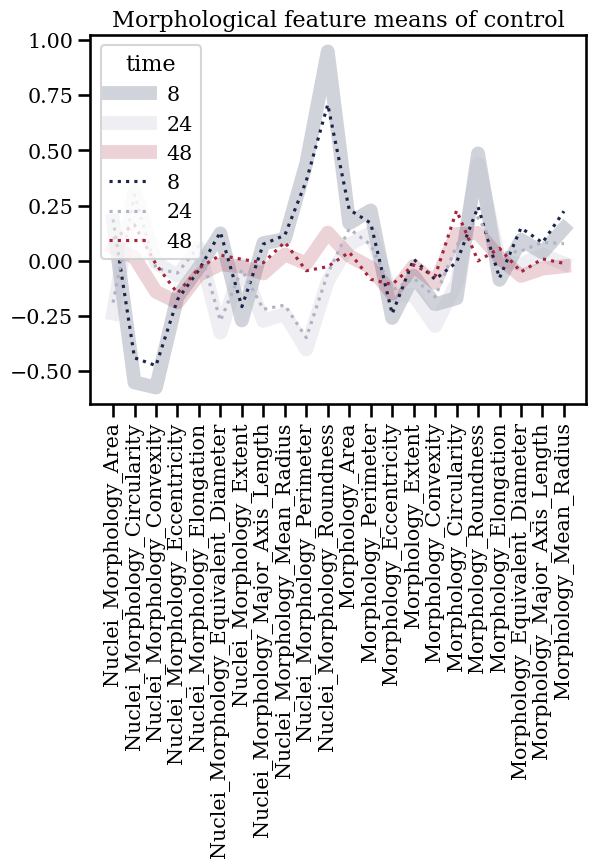

In [16]:
morphology_columns = data.columns[data.columns.str.contains("Morphology")]
ax = plt.gca()
data.loc[conditions == "imatinib", morphology_columns].reset_index().groupby("time").agg('mean').T.plot(ax=ax, lw=10, alpha=.2, cmap=cmap)
data.loc[conditions == "control", morphology_columns].reset_index().groupby("time").agg('mean').T.plot(style=":", cmap=cmap, ax=ax)
plt.xticks(range(morphology_columns.shape[0]), morphology_columns, rotation=90);
plt.title("Morphological feature means of control");

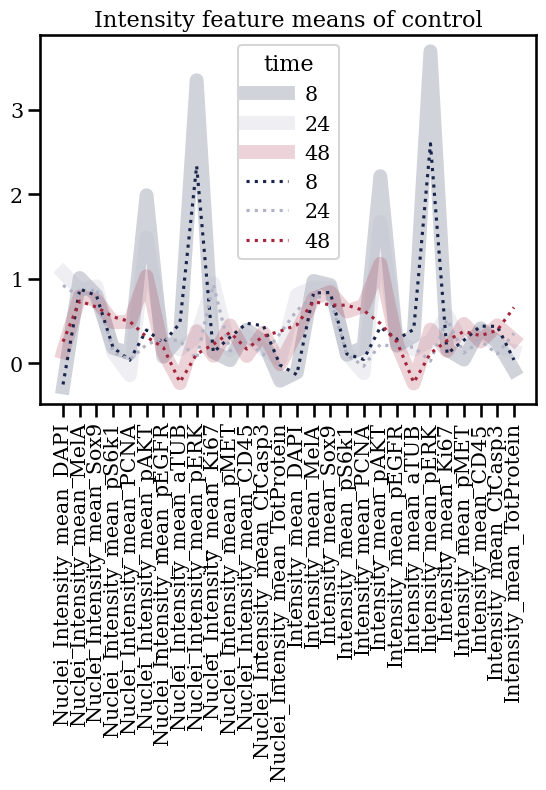

In [17]:
intensity_columns = data.columns[data.columns.str.contains("Intensity")]
ax = plt.gca()
data.loc[conditions == "imatinib", intensity_columns].reset_index().groupby("time").agg('mean').T.plot(ax=ax, lw=10, alpha=.2, cmap=cmap)
data.loc[conditions == "control", intensity_columns].reset_index().groupby("time").agg('mean').T.plot(style=":", cmap=cmap, ax=ax)
plt.xticks(range(intensity_columns.shape[0]), intensity_columns, rotation=90);
plt.title("Intensity feature means of control");

In [23]:
@ipywidgets.interact(d=ipywidgets.Dropdown(options=drugs))
def plot_drug_effect(d):
    plt.figure(figsize=(14, 6))
    [plt.plot(data[conditions == d].loc[t].mean() - data[conditions == "control"].loc[t].mean(), 'o', markersize=12-(i)*3, color=plt.cm.tab10(0), alpha=(i+1)/4, label=f"{d}({t})") for i, t in enumerate([8, 24, 48])];
    plt.xticks(rotation=90);
    plt.title("Deviation from control")
    plt.legend();
    # plt.savefig(f"../figures/usb_cell_{d}_features_evo.svg")

interactive(children=(Dropdown(description='d', options=('ixazomib', 'everolimus', 'olaparib', 'paclitaxel', '…

In [19]:
def compare_evolution_with_baseline(baseline_name, drug_name, feature_name, baseline_timestep=8):
    reference = broadcast(lambda t, _: data.loc[conditions == baseline_name, [feature_name]].loc[baseline_timestep].assign(timeframe=f"{t}h", measurement_type=f"reference({baseline_timestep}h)"), timesteps)
    marginals = broadcast(lambda t, _: data.loc[conditions == drug_name, [feature_name]].loc[t].assign(timeframe=f"{t}h", measurement_type=drug_name), timesteps)

    return pd.concat(list(reference.values()) + list(marginals.values()))

In [20]:
@ipywidgets.interact(feature_name=ipywidgets.Dropdown(options=selected_columns), drug_name=ipywidgets.Dropdown(options=drugs))
def plot_drug_effects_evolution(feature_name, drug_name):
    sbn.violinplot(data=compare_evolution_with_baseline("control", drug_name, feature_name), x=feature_name, y="timeframe", hue="measurement_type", split=True, cut=True)    

interactive(children=(Dropdown(description='feature_name', options=('Nuclei_Morphology_Area', 'Nuclei_Morpholo…

<Axes: xlabel='Nuclei_Intensity_mean_PCNA', ylabel='timeframe'>

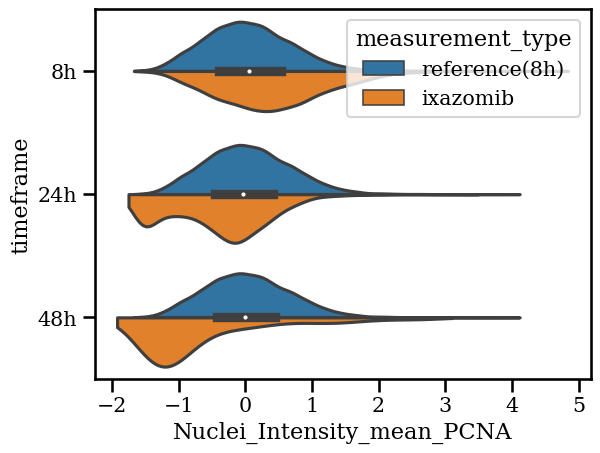

In [21]:
sbn.violinplot(data=compare_evolution_with_baseline("control", "ixazomib", "Nuclei_Intensity_mean_PCNA"), x="Nuclei_Intensity_mean_PCNA", y="timeframe", hue="measurement_type", split=True, cut=True)

### Display counts

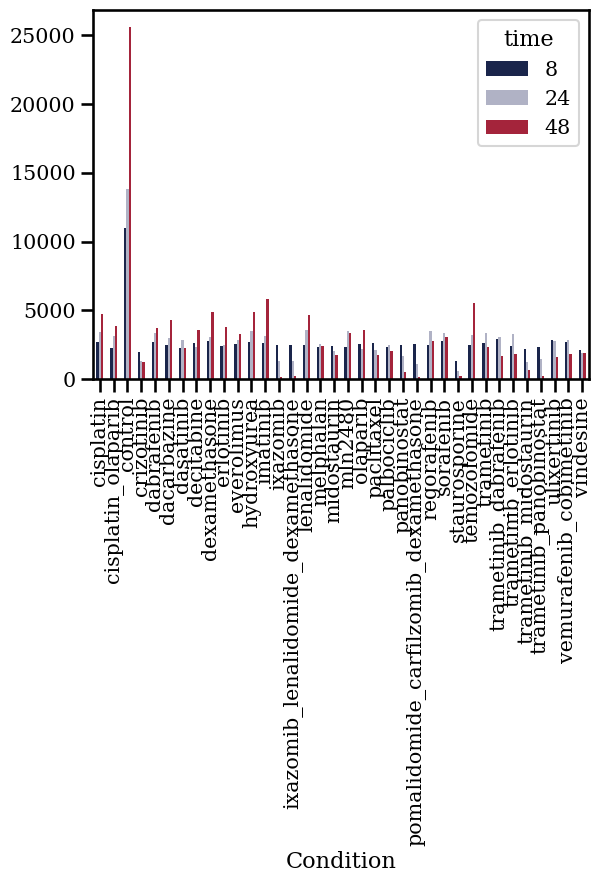

In [22]:
data.assign(Condition=conditions).reset_index().reset_index().groupby(["time", "Condition"]).agg("count").loc[:,"index"].unstack(0).plot.bar(cmap=cmap);

In [23]:
counts_in_time = data.assign(Condition=conditions).query("Condition != 'control'").reset_index().reset_index().groupby(["time", "Condition"]).agg("count").loc[:,["index"]]

In [24]:
counts_in_time

index
time Condition                     
8    cisplatin                 2693
     cisplatin_olaparib        2245
     crizotinib                1978
     dabrafenib                2675
     dacarbazine               2485
...                             ...
48   trametinib_midostaurin     661
     trametinib_panobinostat    270
     ulixertinib               1637
     vemurafenib_cobimetinib   1818
     vindesine                 1892

[105 rows x 1 columns]

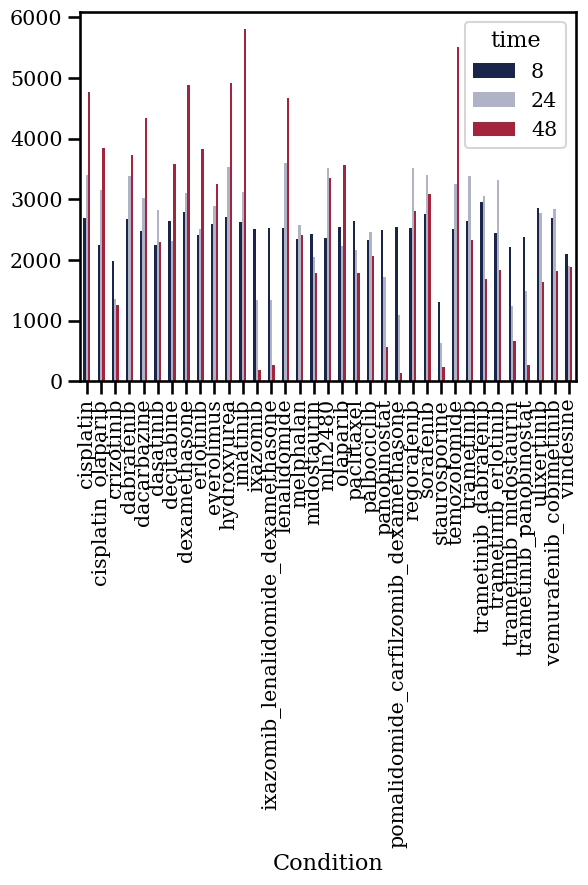

In [25]:
counts_in_time.loc[:,'index'].unstack(0).plot.bar(cmap=cmap);

In [26]:
# Compute mass ratios (wrt to drug @ 8h)
(counts_in_time/counts_in_time.loc[8]).unstack(0).assign(initial_mass=counts_in_time.loc[8]).sort_values("initial_mass", ascending=False)

index                     initial_mass
time                                       8        24        48             
Condition                                                                    
trametinib_dabrafenib                    1.0  1.031778  0.568627         2958
ulixertinib                              1.0  0.969209  0.572778         2858
dexamethasone                            1.0  1.109800  1.748569         2796
sorafenib                                1.0  1.228375  1.115816         2763
hydroxyurea                              1.0  1.303499  1.811418         2715
vemurafenib_cobimetinib                  1.0  1.051577  0.674583         2695
cisplatin                                1.0  1.262532  1.770516         2693
dabrafenib                               1.0  1.262430  1.395888         2675
decitabine                               1.0  0.876133  1.350831         2648
trametinib                               1.0  1.283276  0.884338         2637
paclitaxel                               1.0  0.820561  0.679439         2636
imatinib                                 1.0  1.186621  2.205625         2631
everolimus                               1.0  1.114969  1.256944         2592
pomalidomide_carfilzomib_dexamethasone   1.0  0.431827  0.053831         2545
olaparib                                 1.0  0.875197  1.403937         2540
lenalidomide                             1.0  1.428288  1.848257         2524
regorafenib                              1.0  1.395800  1.110143         2524
ixazomib_lenalidomide_dexamethasone      1.0  0.530928  0.109833         2522
ixazomib                                 1.0  0.532220  0.073588         2514
temozolomide                             1.0  1.292479  2.194986         2513
panobinostat                             1.0  0.691814  0.227528         2492
dacarbazine                              1.0  1.219316  1.744869         2485
trametinib_erlotinib                     1.0  1.354812  0.750816         2452
midostaurin                              1.0  0.844536  0.736907         2425
erlotinib                                1.0  1.044888  1.588529         2406
trametinib_panobinostat                  1.0  0.624737  0.113589         2377
mln2480                                  1.0  1.486692  1.414026         2367
melphalan                                1.0  1.095238  1.025085         2352
palbociclib                              1.0  1.059432  0.887597         2322
dasatinib                                1.0  1.254667  1.019111         2250
cisplatin_olaparib                       1.0  1.404454  1.710913         2245
trametinib_midostaurin                   1.0  0.562641  0.298960         2211
vindesine                                1.0  0.901998  0.900095         2102
crizotinib                               1.0  0.689080  0.639535         1978
staurosporine                            1.0  0.488550  0.181679         1310

In [27]:
def extract_by_condition(data, condition, columns=selected_columns):
    return data.loc[conditions == condition, columns]

In [28]:
def downsample(data, max_samples):
    selected_idxs = np.random.permutation(data.index)[:max_samples]
    return data.loc[selected_idxs,:]

In [29]:
dataset_version = "v2"
drug_name = "trametinib_erlotinib"

# dataset_version = "v4"
# drug_name = "ulixertinib"

In [ ]:
# train_idxs, test_idxs = sk.model_selection.train_test_split(np.arange(data.shape[0]), test_size=.2)
# np.savez(f"./4i/{dataset_version}_full-4i_train_test_split_idxs.npz", train_idxs=train_idxs, test_idxs=test_idxs)

idxs_file = np.load(f"./4i/{dataset_version}_full-4i_train_test_split_idxs.npz")
train_idxs, test_idxs = idxs_file['train_idxs'], idxs_file['test_idxs']

In [34]:
selected_drug_idxs = np.where(conditions == drug_name)[0]

In [35]:
# Save normalized data (before projection)
data.assign(Condition=conditions).to_csv(f"./4i/{dataset_version}_full-4i_normalized.csv")

In [36]:
np.save(f"./4i/{dataset_version}_full-4i_t0_points.npy", data.iloc[np.intersect1d(train_idxs, selected_drug_idxs)].query(f"time == 8").to_numpy())
np.save(f"./4i/{dataset_version}_full-4i_t1_points.npy", data.iloc[np.intersect1d(train_idxs, selected_drug_idxs)].query(f"time == 48").to_numpy())

np.save(f"./4i/{dataset_version}_full-4i_test_t0_points.npy", data.iloc[np.intersect1d(test_idxs, selected_drug_idxs)].query(f"time == 8").to_numpy())
np.save(f"./4i/{dataset_version}_full-4i_test_t1_points.npy", data.iloc[np.intersect1d(test_idxs, selected_drug_idxs)].query(f"time == 48").to_numpy())

In [37]:
full_proj = PCA(2)
full_proj.fit(data.iloc[np.intersect1d(train_idxs, selected_drug_idxs)].to_numpy())
joblib.dump(full_proj, f"./4i/{dataset_version}_full-4i_pca.pkl")

['./4i/v4_full-4i_pca.pkl']

### Project timeframes

In [39]:
@ipywidgets.interact(drug=ipywidgets.Dropdown(value=drug_name, options=drugs))
def evolution_under_drug(drug):
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[8].to_numpy()).T, s=5., alpha=.4, label="8", color=cmap(0.))
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[24].to_numpy()).T, s=5., alpha=.4, label="24", color=cmap(.5))
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[48].to_numpy()).T, s=5., alpha=.4, label="48", color=cmap(1.))
    plt.legend();
    plt.title(f"Time evolution under {drug}");

interactive(children=(Dropdown(description='drug', index=34, options=('ixazomib', 'everolimus', 'olaparib', 'p…

In [41]:
@ipywidgets.interact(drug=ipywidgets.Dropdown(value=drug_name, options=drugs))
def evolution_under_drug(drug):
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[8].to_numpy()).T, s=2., alpha=.6, label="8", color=cmap(0.))
    # plt.scatter(*pca.transform(data.loc[conditions == drug].loc[24].to_numpy()).T, s=2., alpha=.2, label="24", color=cmap(.5))
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[48].to_numpy()).T, s=2., alpha=.1, label="48", color=cmap(1.))
    plt.legend();
    plt.title(f"Time evolution under {drug}");

interactive(children=(Dropdown(description='drug', index=34, options=('ixazomib', 'everolimus', 'olaparib', 'p…

In [43]:
@ipywidgets.interact(drug=ipywidgets.Dropdown(value=drug_name, options=drugs))
def evolution_under_drug(drug):
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[48].to_numpy()).T, s=2., alpha=.6, label="48", color=cmap(1.))
    # plt.scatter(*pca.transform(data.loc[conditions == drug].loc[24].to_numpy()).T, s=2., alpha=.2, label="24", color=cmap(.5))
    plt.scatter(*full_proj.transform(data.loc[conditions == drug].loc[8].to_numpy()).T, s=2., alpha=.1, label="8", color=cmap(0.))
    plt.legend();
    plt.title(f"Time evolution under {drug}");


interactive(children=(Dropdown(description='drug', index=34, options=('ixazomib', 'everolimus', 'olaparib', 'p…

In [ ]:
# # Save normalized file
# data.assign(Condition=conditions).to_csv(f"./4i/{dataset_version}_{dataset_name}_normalized.csv")